#📌 Extracción

In [26]:
import pandas as  pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
datos = pd.read_csv('datos_tratados.csv')
datos.head()

,id_cliente,abandono,genero,es_ciudadano_senior,tiene_pareja,tiene_dependientes,meses_en_empresa,servicio_telefonico,lineas_multiples,tipo_internet,...,proteccion_dispositivo,soporte_tecnico,tv_streaming,peliculas_streaming,tipo_contrato,factura_electronica,metodo_pago,cargos_mensuales,cargos_totales,cuentas_diarias
0,0002-ORFBO,0,Female,0,1,1,9,1,No,DSL,...,No,Yes,Yes,No,one year,1,mailed check,65.6,593.30,2.186667
1,0003-MKNFE,0,Male,0,0,0,9,1,Yes,DSL,...,No,No,No,Yes,month to month,0,mailed check,59.9,542.40,1.996667
2,0004-TLHLJ,1,Male,0,0,0,4,1,No,Fiber optic,...,Yes,No,No,No,month to month,1,electronic check,73.9,280.85,2.463333
3,0011-IGKFF,1,Male,1,1,0,13,1,No,Fiber optic,...,Yes,No,Yes,Yes,month to month,1,electronic check,98.0,1237.85,3.266667
4,0013-EXCHZ,1,Female,1,1,0,3,1,No,Fiber optic,...,No,Yes,Yes,No,month to month,1,mailed check,83.9,267.40,2.796667


#🔧 Transformación

In [37]:
# Eliminar columna de ID único
if 'id_cliente' in datos.columns:
    datos.drop(columns=['id_cliente'], inplace=True)

# Eliminar columnas constantes
constant_columns = [col for col in datos.columns if datos[col].nunique() == 1]
if constant_columns:
    datos.drop(columns=constant_columns, inplace=True)
    print(f"Columnas constantes eliminadas: {constant_columns}")

# Verificar las columnas restantes
print("\nColumnas restantes en el dataset:")
print(datos.columns.tolist())


Columnas restantes en el dataset:
['abandono', 'genero', 'es_ciudadano_senior', 'tiene_pareja', 'tiene_dependientes', 'meses_en_empresa', 'servicio_telefonico', 'lineas_multiples', 'tipo_internet', 'seguridad_online', 'respaldo_online', 'proteccion_dispositivo', 'soporte_tecnico', 'tv_streaming', 'peliculas_streaming', 'tipo_contrato', 'factura_electronica', 'metodo_pago', 'cargos_mensuales', 'cargos_totales', 'cuentas_diarias']


In [43]:
# Detectar columnas cuyos valores son todos únicos (número de valores únicos == número de filas)
unique_cols = [
    col
    for col in datos.columns
    if datos[col].nunique() == datos.shape[0]
]
print("Columnas únicas detectadas:", unique_cols)

# Eliminar ambas listas de columnas del DataFrame
cols_to_drop = list(set(unique_cols + manual_drops))
datos = datos.drop(columns=cols_to_drop, errors='ignore')

# Verificar que las columnas hayan sido eliminadas
print("Dimensiones antes:", datos.shape[0] + len(cols_to_drop), "filas x … columnas")
print("Dimensiones después:", datos.shape)

Columnas únicas detectadas: []
Dimensiones antes: 7259 filas x … columnas
Dimensiones después: (7256, 21)


#📊 Carga y análisis

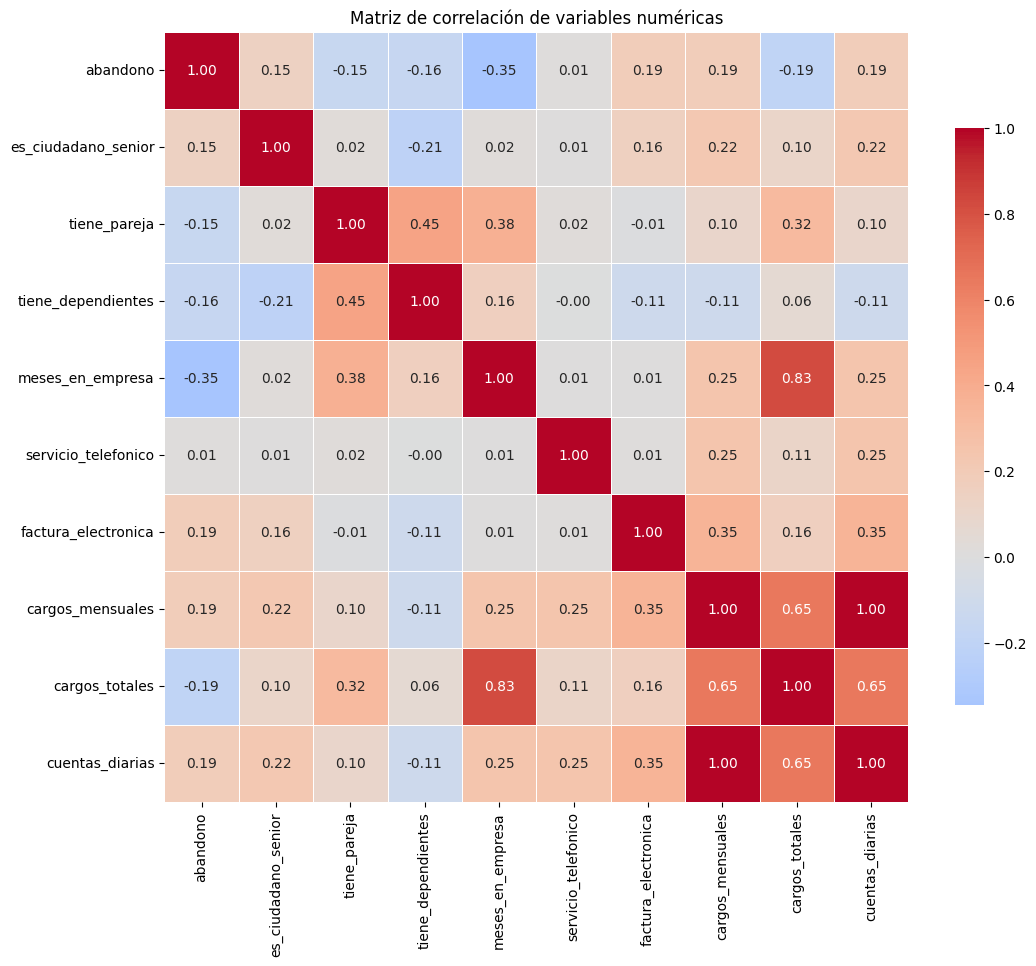

Variables más correlacionadas con abandono:
cuentas_diarias        0.189393
cargos_mensuales       0.189393
factura_electronica    0.186309
es_ciudadano_senior    0.146400
servicio_telefonico    0.012337
tiene_pareja          -0.148106
tiene_dependientes    -0.160347
cargos_totales        -0.194440
meses_en_empresa      -0.345799
Name: abandono, dtype: float64


In [41]:

# Carga de datos
# Suponemos que tu DataFrame se llama `datos` y la columna de abandono es 'abandono'
datos = pd.read_csv('datos_tratados.csv')

# Selección de variables numéricas
num_cols = datos.select_dtypes(include=['int64', 'float64']).columns

# Cálculo de la matriz de correlación
corr_matrix = datos[num_cols].corr()

# Visualización con heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt='.2f',
    cmap='coolwarm',
    center=0,
    linewidths=0.5,
    cbar_kws={'shrink': 0.75}
)
plt.title('Matriz de correlación de variables numéricas')
plt.show()

# 5. Correlación de cada variable con la cancelación
corr_with_target = corr_matrix['abandono'].drop('abandono').sort_values(ascending=False)

print("Variables más correlacionadas con abandono:")
print(corr_with_target.head(10))


In [45]:
# Asumiendo que tu DataFrame ya está cargado en `datos`

# Conteo de cada clase en la columna 'abandono'
conteos = datos['abandono'].value_counts()
print("Conteos de abandono vs activo:\n", conteos)

# Proporciones normalizadas
proporciones = datos['abandono'].value_counts(normalize=True)
print("\nProporciones de abandono vs activo:\n", proporciones)

# Calcular ratio abandono / activo
#    Ajusta los valores según tus etiquetas (por ejemplo 'Sí' y 'No')
p_abandono = proporciones.get('Sí', proporciones.get(1, 0))
p_activos  = proporciones.get('No', proporciones.get(0, 0))

if p_activos > 0:
    ratio = p_abandono / p_activos
    print(f"\nRatio abandono/activo: {ratio:.2f}")
else:
    print("\nNo hay registros de clientes activos para calcular el ratio.")

Conteos de abandono vs activo:
 abandono
0    5387
1    1869
Name: count, dtype: int64

Proporciones de abandono vs activo:
 abandono
0    0.74242
1    0.25758
Name: proportion, dtype: float64

Ratio abandono/activo: 0.35


In [47]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Si vas a usar XGBoost:
# pip install xgboost
from xgboost import XGBClassifier

# 1. Carga de datos
data = load_breast_cancer(as_frame=True)
X, y = data.data, data.target

# Definición de modelos
models = {
    # Modelos sensibles a la escala
    'KNN': KNeighborsClassifier(),
    'SVM': SVC(kernel='rbf', probability=True, random_state=42),
    'LogisticRegression': LogisticRegression(solver='lbfgs', max_iter=1000, random_state=42),
    'NeuralNet': MLPClassifier(hidden_layer_sizes=(50,), max_iter=500, random_state=42),
    # Modelos insensibles a la escala
    'DecisionTree': DecisionTreeClassifier(random_state=42),
    'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

# 3. Función para crear pipeline
def make_pipeline(model, scale: bool):
    steps = []
    if scale:
        steps.append(('scaler', StandardScaler()))
    steps.append(('clf', model))
    return Pipeline(steps)

# 4. Preparar validación cruzada
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

# 5. Ejecutar cross-validate para cada modelo
results = []

for name, model in models.items():
    for scale in ([True, False] if name in ['KNN', 'SVM', 'LogisticRegression', 'NeuralNet']
                  else [(False)]):
        pipe = make_pipeline(model, scale)
        cv = cross_validate(pipe, X, y,
                            cv=skf,
                            scoring=scoring,
                            return_train_score=False)

        results.append({
            'Model': name,
            'Scaled': scale,
            'Accuracy': np.mean(cv['test_accuracy']),
            'Precision': np.mean(cv['test_precision']),
            'Recall': np.mean(cv['test_recall']),
            'F1': np.mean(cv['test_f1']),
            'ROC AUC': np.mean(cv['test_roc_auc'])
        })

df_results = pd.DataFrame(results).sort_values(['Model', 'Scaled'], ascending=[True, False])
print(df_results.to_markdown(index=False))


| Model              | Scaled   |   Accuracy |   Precision |   Recall |       F1 |   ROC AUC |
|:-------------------|:---------|-----------:|------------:|---------:|---------:|----------:|
| DecisionTree       | False    |   0.910402 |    0.919698 | 0.941236 | 0.929871 |  0.90002  |
| KNN                | True     |   0.963096 |    0.957187 | 0.986072 | 0.971183 |  0.984865 |
| KNN                | False    |   0.93501  |    0.938657 | 0.960837 | 0.948953 |  0.965548 |
| LogisticRegression | True     |   0.973669 |    0.968254 | 0.991588 | 0.979434 |  0.995314 |
| LogisticRegression | False    |   0.947306 |    0.949099 | 0.96921  | 0.958523 |  0.993016 |
| NeuralNet          | True     |   0.978932 |    0.978556 | 0.988811 | 0.983366 |  0.996031 |
| NeuralNet          | False    |   0.93501  |    0.917299 | 0.986033 | 0.950255 |  0.98683  |
| RandomForest       | False    |   0.956094 |    0.96509  | 0.966471 | 0.965068 |  0.988548 |
| SVM                | True     |   0.977162 |    

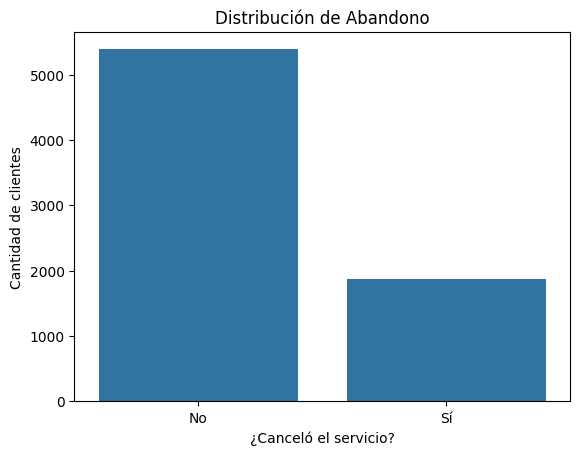

In [51]:
sns.countplot(data=datos, x='abandono')
plt.title('Distribución de Abandono')
plt.xlabel('¿Canceló el servicio?')
plt.ylabel('Cantidad de clientes')
plt.xticks([0, 1], ['No', 'Sí'])
plt.show()

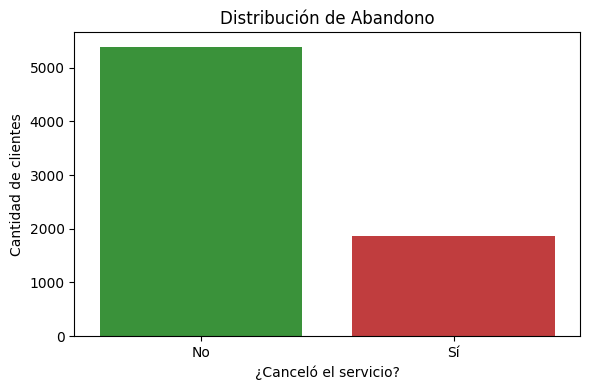

In [52]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Definir una paleta de colores personalizada
#    Ejemplo: verde para 'No' y rojo para 'Sí'
palette = ['#2ca02c', '#d62728']

# 2. Dibujar countplot con la paleta definida
plt.figure(figsize=(6, 4))
sns.countplot(
    data=datos,
    x='abandono',
    palette=palette
)

# 3. Ajustes de texto y etiquetas
plt.title('Distribución de Abandono')
plt.xlabel('¿Canceló el servicio?')
plt.ylabel('Cantidad de clientes')
plt.xticks([0, 1], ['No', 'Sí'])

# 4. Mostrar la gráfica
plt.tight_layout()
plt.show()


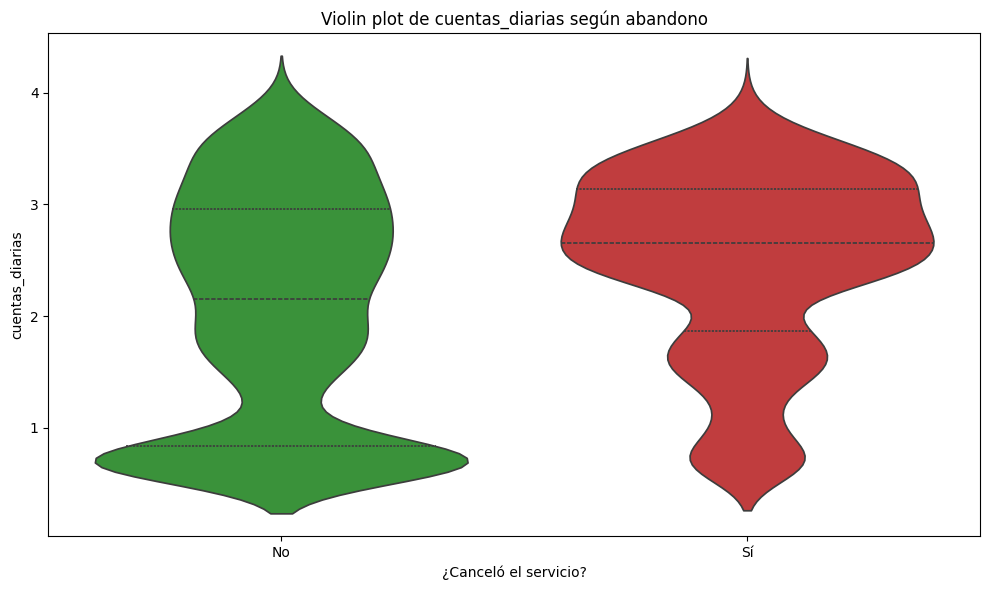

In [58]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.violinplot(
    data=datos,
    x='abandono',
    y=col,          # reemplaza `col` por cada variable numérica en tu bucle
    palette=['#2ca02c', '#d62728'],
    inner='quartile'
)
plt.title(f'Violin plot de {col} según abandono')
plt.xlabel('¿Canceló el servicio?')
plt.ylabel(col)
plt.xticks([0, 1], ['No', 'Sí'])
plt.tight_layout()
plt.show()


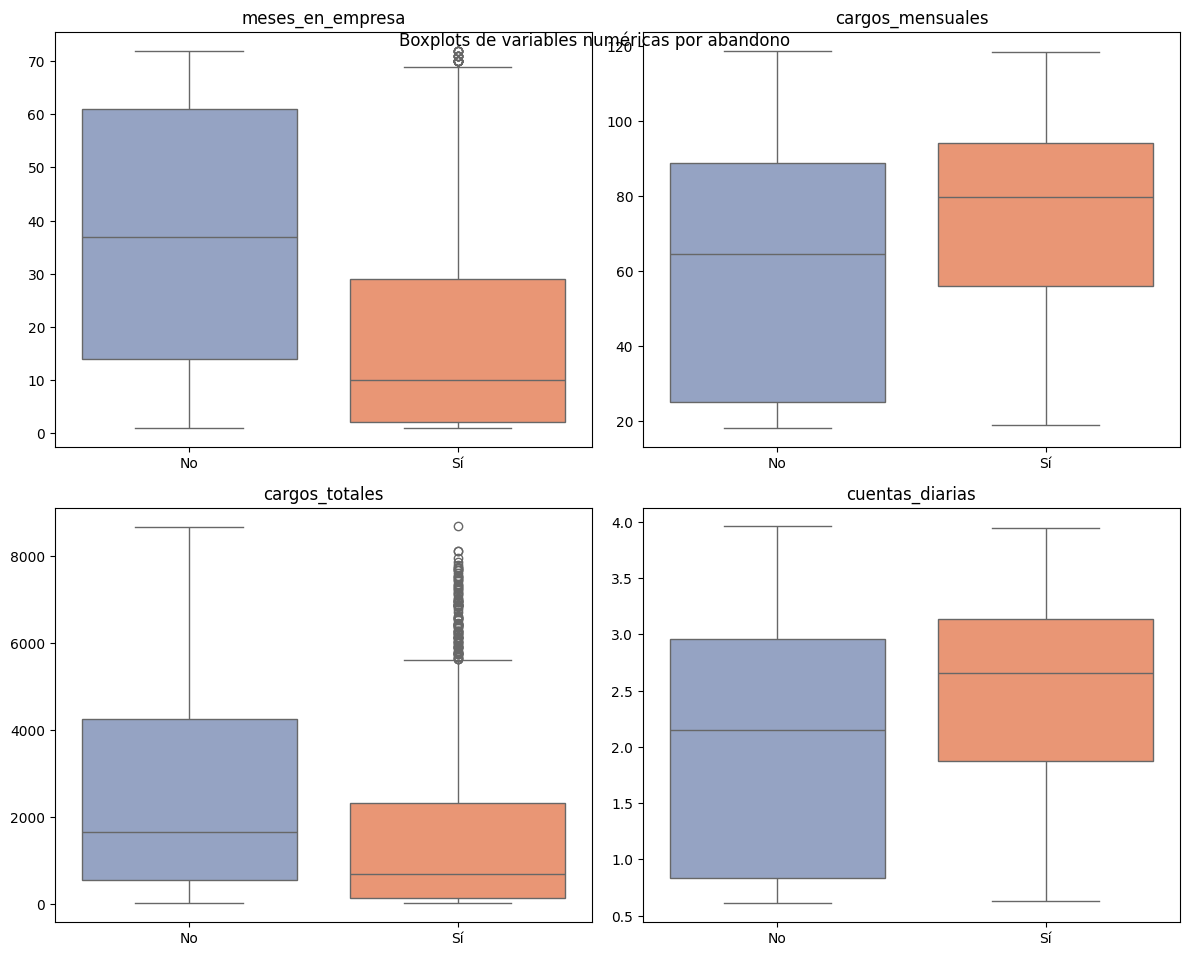

In [59]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for ax, col in zip(axes, numericas):
    sns.boxplot(
        data=datos,
        x='abandono',
        y=col,
        palette=['#8da0cb', '#fc8d62'],
        ax=ax
    )
    ax.set_title(f'{col}')
    ax.set_xlabel('')
    ax.set_xticklabels(['No', 'Sí'])
    ax.set_ylabel('')

fig.suptitle('Boxplots de variables numéricas por abandono', y=0.93)
plt.tight_layout()
plt.show()


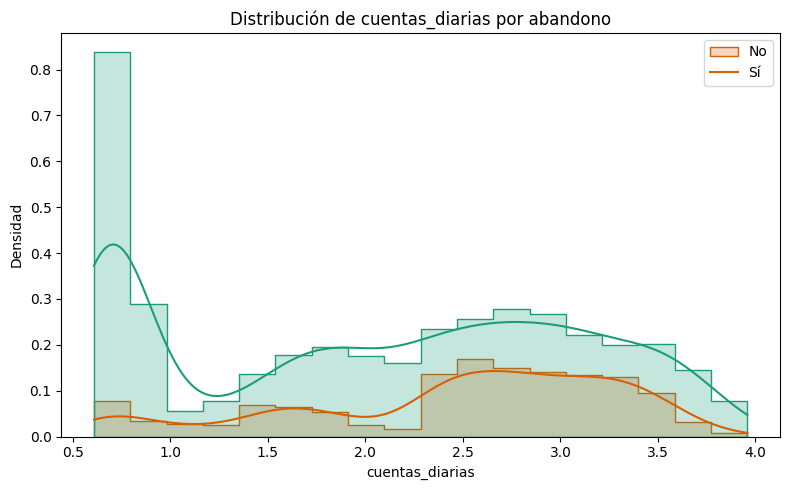

In [60]:
plt.figure(figsize=(8, 5))
sns.histplot(
    data=datos,
    x=col,                    # itera con tus variables numéricas
    hue='abandono',
    kde=True,
    element='step',
    stat='density',
    palette=['#1b9e77','#d95f02']
)
plt.title(f'Distribución de {col} por abandono')
plt.xlabel(col)
plt.ylabel('Densidad')
plt.legend(['No', 'Sí'])
plt.tight_layout()
plt.show()


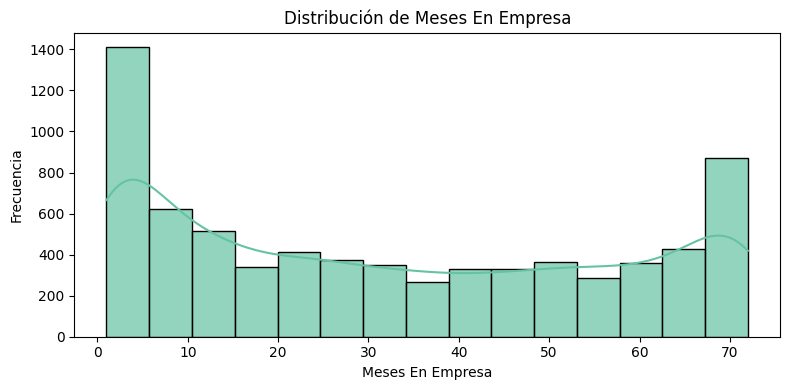

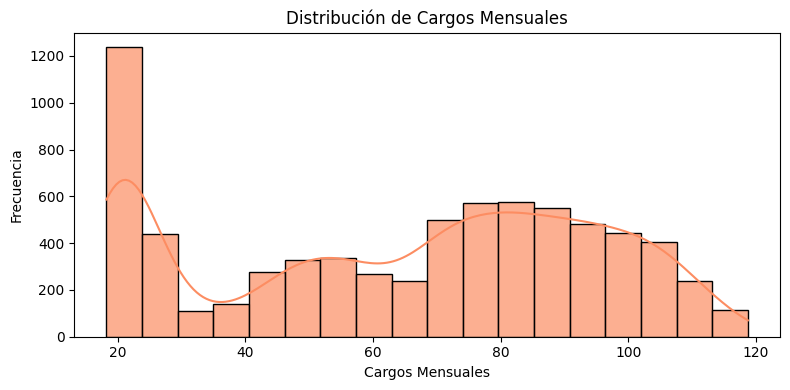

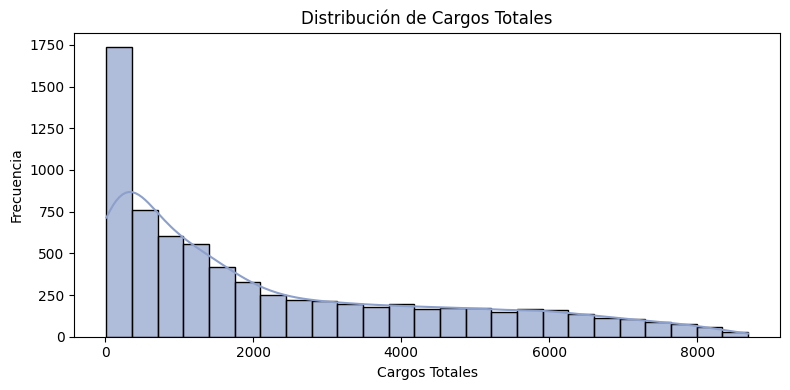

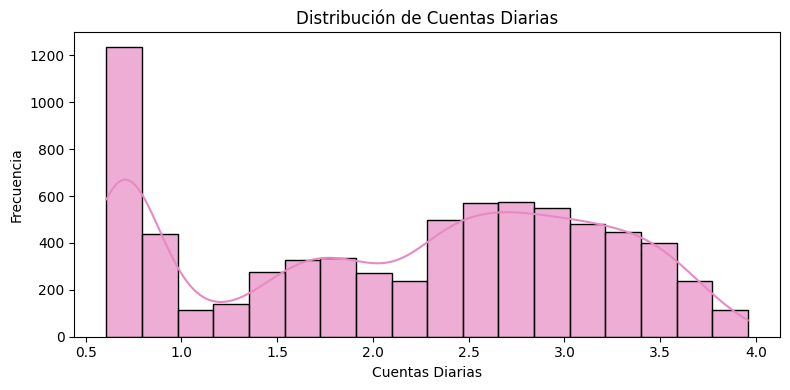

In [62]:
def ancho_bin(df, columna):
    q75, q25 = np.percentile(df[columna], [75, 25])
    iqr = q75 - q25
    return 2 * iqr * len(df[columna]) ** (-1/3)

# Lista de variables numéricas
numericas = ['meses_en_empresa', 'cargos_mensuales', 'cargos_totales', 'cuentas_diarias']

# Definir paleta de colores con tantos tonos como variables
palette = sns.color_palette('Set2', len(numericas))

for i, col in enumerate(numericas):
    binwidth = ancho_bin(datos, col)
    pretty_name = col.replace('_', ' ').title()   # e.g. 'meses_en_empresa' → 'Meses En Empresa'

    plt.figure(figsize=(8, 4))
    sns.histplot(
        data=datos,
        x=col,
        kde=True,
        binwidth=binwidth,
        color=palette[i],
        edgecolor='black',
        alpha=0.7
    )
    plt.title(f'Distribución de {pretty_name}')
    plt.xlabel(pretty_name)
    plt.ylabel('Frecuencia')
    plt.tight_layout()
    plt.show()


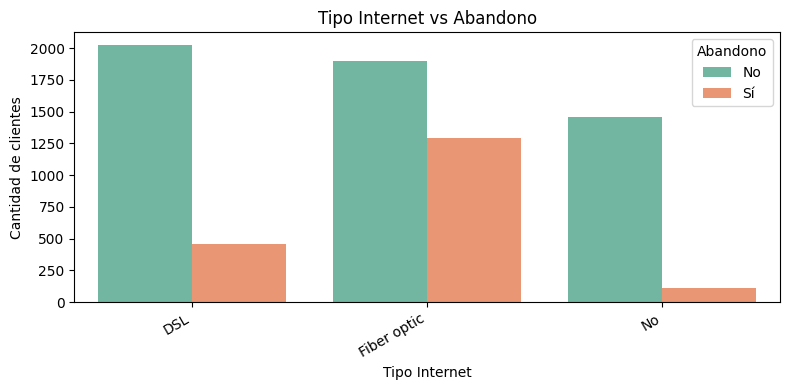

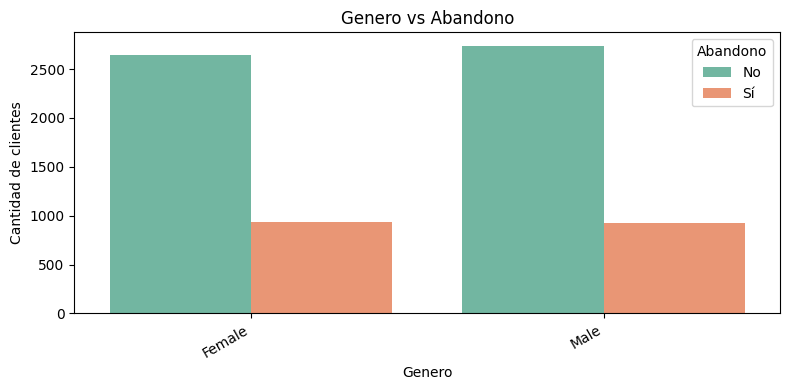

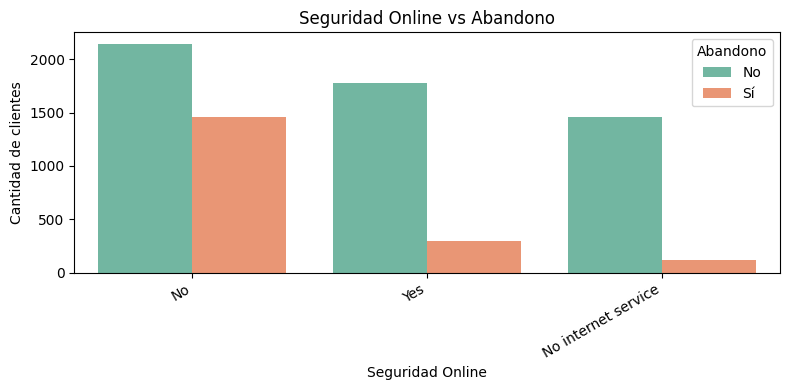

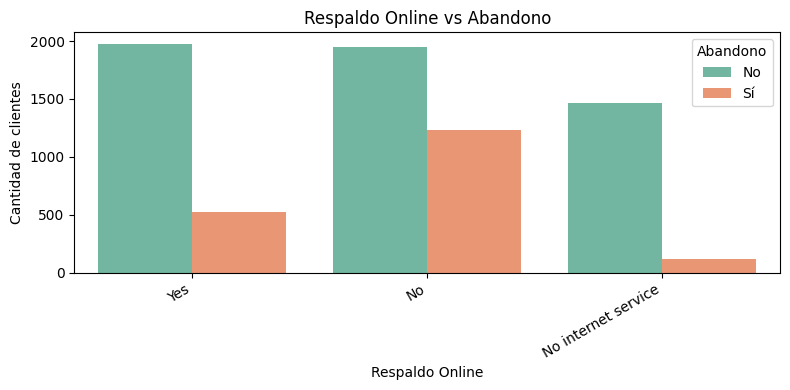

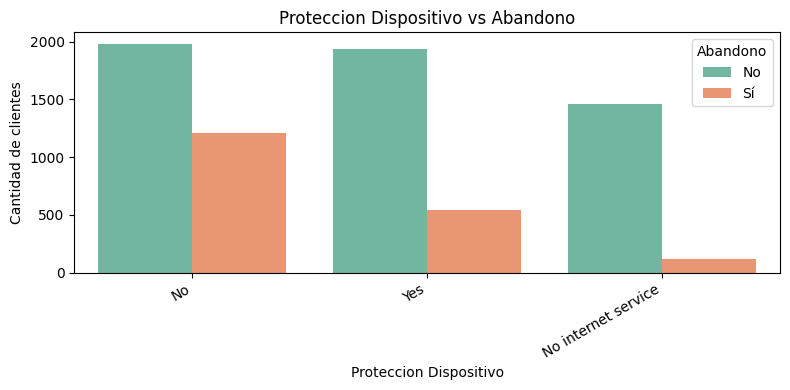

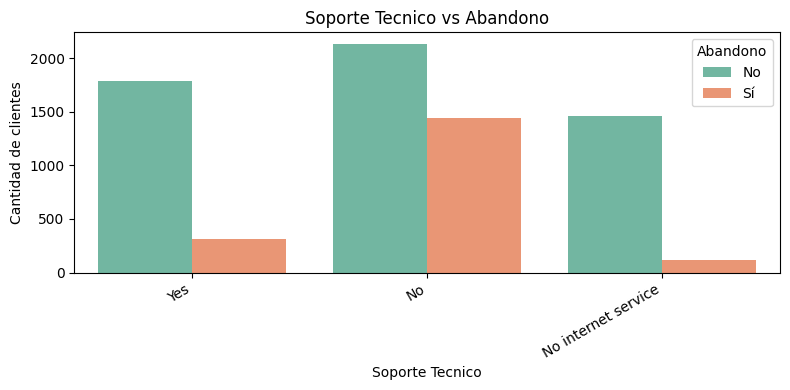

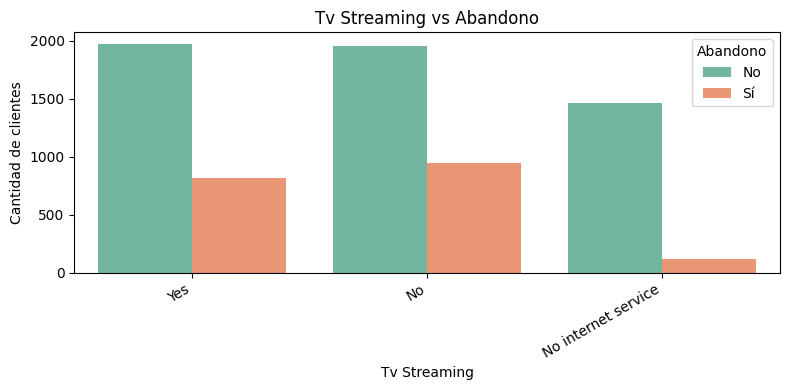

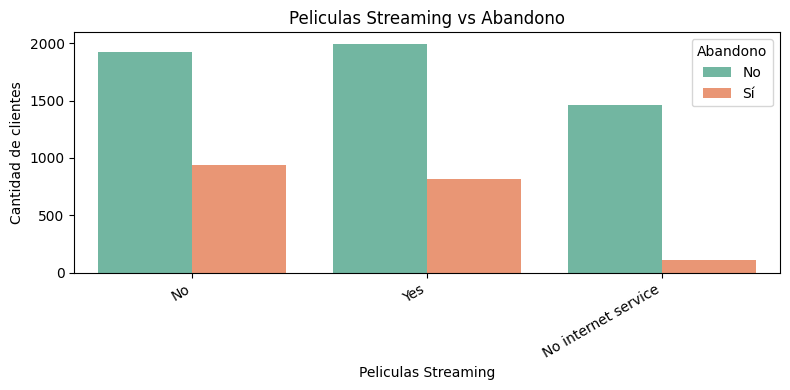

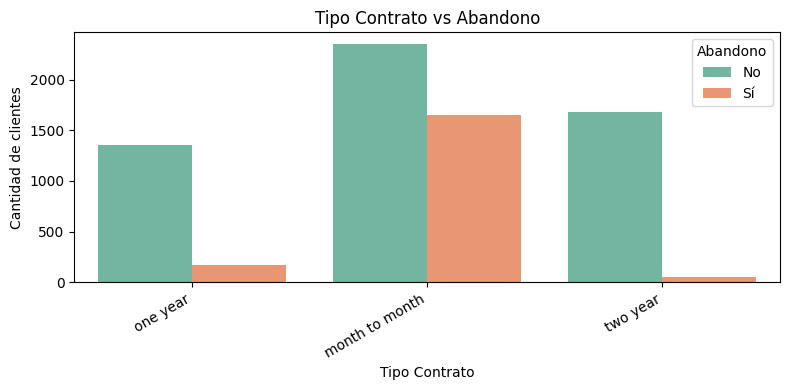

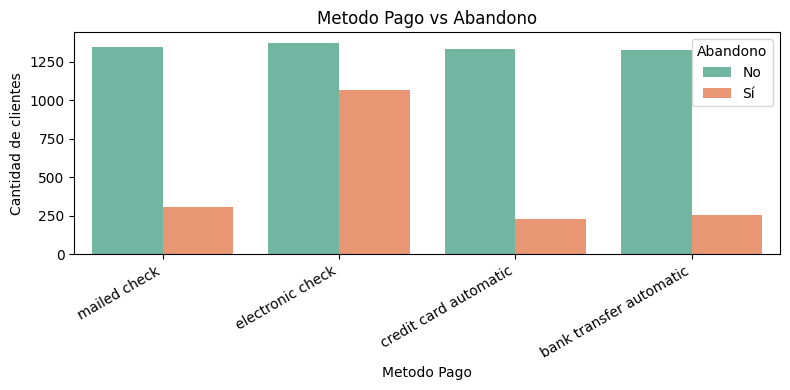

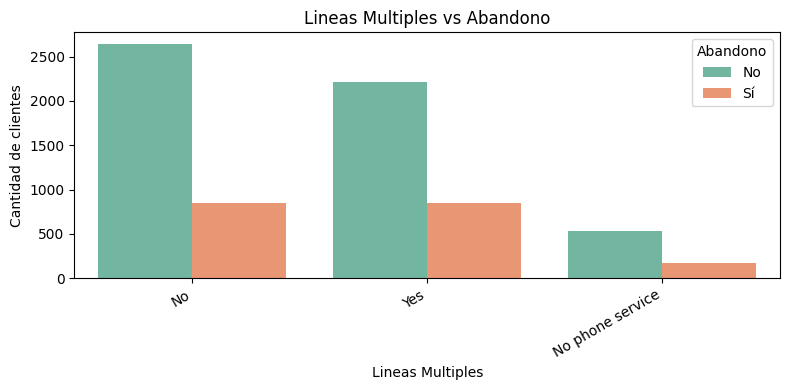

In [63]:
import seaborn as sns
import matplotlib.pyplot as plt

# Paleta para hue (0 = No, 1 = Sí)
palette_hue = sns.color_palette("Set2", 2)

categoricas = [
    'tipo_internet', 'genero', 'seguridad_online', 'respaldo_online',
    'proteccion_dispositivo', 'soporte_tecnico', 'tv_streaming',
    'peliculas_streaming', 'tipo_contrato', 'metodo_pago',
    'lineas_multiples'
]

for col in categoricas:
    # Formatear nombre para títulos y etiquetas
    pretty_name = col.replace('_', ' ').title()

    fig, ax = plt.subplots(figsize=(8, 4))
    sns.countplot(
        data=datos,
        x=col,
        hue='abandono',
        hue_order=[0, 1],
        palette=palette_hue,
        ax=ax
    )

    # Títulos y etiquetas mejorados
    ax.set_title(f'{pretty_name} vs Abandono')
    ax.set_xlabel(pretty_name)
    ax.set_ylabel('Cantidad de clientes')

    # Rotar y alinear las etiquetas del eje x
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')

    # Personalizar leyenda
    ax.legend(title='Abandono', labels=['No', 'Sí'])

    plt.tight_layout()
    plt.show()


In [71]:
import numpy as np
import pandas as pd

# 1. Columnas categóricas y numéricas originales
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns
num_cols = X_train.select_dtypes(include=['int64', 'float64']).columns

# 2. Extraer nombres de features tras preprocesamiento

## 2.1 Para Regresión Logística
preproc_lr = pipe_lr.named_steps['preproc']
ohe_lr    = preproc_lr.named_transformers_['ohe']

ohe_feats_lr    = ohe_lr.get_feature_names_out(cat_cols)
feature_names_lr = np.concatenate([ohe_feats_lr, num_cols])

## 2.2 Para Random Forest
preproc_rf = pipe_rf.named_steps['preproc']
ohe_rf     = preproc_rf.named_transformers_['ohe']

ohe_feats_rf    = ohe_rf.get_feature_names_out(cat_cols)
feature_names_rf = np.concatenate([ohe_feats_rf, num_cols])  # remainder pasa los num_cols

# 3. Obtener importancias

## 3.1 Coeficientes de Regresión Logística
coefs_lr = pipe_lr.named_steps['clf'].coef_[0]
df_lr = pd.DataFrame({
    'feature': feature_names_lr,
    'coef_lr': coefs_lr
})
df_lr['abs_coef_lr'] = df_lr['coef_lr'].abs()

## 3.2 Importancias de Random Forest
imps_rf = pipe_rf.named_steps['clf'].feature_importances_
df_rf = pd.DataFrame({
    'feature': feature_names_rf,
    'imp_rf': imps_rf
})
df_rf['imp_rf'] = df_rf['imp_rf'].abs()

# 4. Unir en una sola tabla y ordenar por suma de importancias
df_merge = pd.merge(df_lr[['feature','abs_coef_lr']],
                    df_rf[['feature','imp_rf']],
                    on='feature',
                    how='outer').fillna(0)

df_merge['importance_sum'] = df_merge['abs_coef_lr'] + df_merge['imp_rf']
df_merge = df_merge.sort_values('importance_sum', ascending=False)

# 5. Mostrar top 10 factores
top10 = df_merge.head(10).reset_index(drop=True)
print("\nTop 10 factores que más influyen en la cancelación:\n")
print(top10.to_markdown(index=False, floatfmt=".4f"))



Top 10 factores que más influyen en la cancelación:

| feature                   |   abs_coef_lr |   imp_rf |   importance_sum |
|:--------------------------|--------------:|---------:|-----------------:|
| meses_en_empresa          |        1.3867 |   0.0889 |           1.4756 |
| tipo_contrato_two year    |        1.2607 |   0.0211 |           1.2818 |
| tipo_internet_Fiber optic |        0.9093 |   0.0244 |           0.9336 |
| id_cliente_0607-DAAHE     |        0.9263 |   0.0005 |           0.9268 |
| id_cliente_3400-ESFUW     |        0.9243 |   0.0004 |           0.9246 |
| id_cliente_3512-IZIKN     |        0.9232 |   0.0003 |           0.9235 |
| id_cliente_1043-YCUTE     |        0.9217 |   0.0004 |           0.9221 |
| id_cliente_6532-YLWSI     |        0.9189 |   0.0005 |           0.9193 |
| id_cliente_8631-NBHFZ     |        0.9178 |   0.0002 |           0.9180 |
| id_cliente_4597-ELFTS     |        0.9129 |   0.0003 |           0.9132 |


In [64]:
from sklearn.model_selection import train_test_split

# Definir características X y variable objetivo y
X = datos.drop('abandono', axis=1)
y = datos['abandono']

# División 70% entrenamiento / 30% prueba
X_train_70, X_test_30, y_train_70, y_test_30 = train_test_split(
    X,
    y,
    test_size=0.30,       # 30% para prueba
    random_state=42,      # semilla para reproducibilidad
    stratify=y            # mantiene proporción de clases de abandono
)

print("70/30 split:")
print(f"  X_train: {X_train_70.shape}, X_test: {X_test_30.shape}")
print(f"  y_train: {y_train_70.shape}, y_test: {y_test_30.shape}")


# División 80% entrenamiento / 20% prueba
X_train_80, X_test_20, y_train_80, y_test_20 = train_test_split(
    X,
    y,
    test_size=0.20,       # 20% para prueba
    random_state=42,
    stratify=y
)

print("\n80/20 split:")
print(f"  X_train: {X_train_80.shape}, X_test: {X_test_20.shape}")
print(f"  y_train: {y_train_80.shape}, y_test: {y_test_20.shape}")


70/30 split:
  X_train: (5079, 21), X_test: (2177, 21)
  y_train: (5079,), y_test: (2177,)

80/20 split:
  X_train: (5804, 21), X_test: (1452, 21)
  y_train: (5804,), y_test: (1452,)


In [69]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# 1. Separar X e y y división 80/20
X = datos.drop('abandono', axis=1)
y = datos['abandono']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    stratify=y,
    random_state=42
)

# Detectar automáticamente columnas numéricas y categóricas
num_cols = make_column_selector(dtype_include=['int64', 'float64'])
cat_cols = make_column_selector(dtype_include=['object', 'category'])

# Preprocesadores con ColumnTransformer

# Para el modelo sensible a la escala (Regresión Logística)
preproc_lr = ColumnTransformer([
    # One-hot para categóricas
    ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_cols),
    # StandardScaler para numéricas
    ('scaler', StandardScaler(), num_cols)
])

# Para el modelo insensible a la escala (Random Forest)
preproc_rf = ColumnTransformer([
    # One-hot para categóricas
    ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_cols)
    # Las numéricas quedan “passthrough” (sin escala)
], remainder='passthrough')

# Pipelines
pipe_lr = Pipeline([
    ('preproc', preproc_lr),
    ('clf', LogisticRegression(random_state=42, max_iter=1000))
])

pipe_rf = Pipeline([
    ('preproc', preproc_rf),
    ('clf', RandomForestClassifier(n_estimators=100, random_state=42))
])

# Entrenamiento
pipe_lr.fit(X_train, y_train)
pipe_rf.fit(X_train, y_train)

# Predicción
y_pred_lr = pipe_lr.predict(X_test)
y_pred_rf = pipe_rf.predict(X_test)

# Evaluación
print("=== Regresión Logística (con escalado) ===")
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))
print("Matriz de confusión:\n", confusion_matrix(y_test, y_pred_lr))

print("\n=== Random Forest (sin escalado) ===")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))
print("Matriz de confusión:\n", confusion_matrix(y_test, y_pred_rf))


=== Regresión Logística (con escalado) ===
Accuracy: 0.7933884297520661
              precision    recall  f1-score   support

           0       0.84      0.88      0.86      1078
           1       0.61      0.53      0.57       374

    accuracy                           0.79      1452
   macro avg       0.73      0.71      0.72      1452
weighted avg       0.79      0.79      0.79      1452

Matriz de confusión:
 [[953 125]
 [175 199]]

=== Random Forest (sin escalado) ===
Accuracy: 0.7844352617079889
              precision    recall  f1-score   support

           0       0.82      0.91      0.86      1078
           1       0.62      0.41      0.49       374

    accuracy                           0.78      1452
   macro avg       0.72      0.66      0.68      1452
weighted avg       0.77      0.78      0.77      1452

Matriz de confusión:
 [[986  92]
 [221 153]]


In [70]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix
)

def eval_model(name, model, X_tr, y_tr, X_te, y_te):
    # Predicciones
    y_tr_pred = model.predict(X_tr)
    y_te_pred = model.predict(X_te)

    # Métricas
    metrics = {
        'Accuracy (train)': accuracy_score(y_tr, y_tr_pred),
        'Accuracy (test)':  accuracy_score(y_te, y_te_pred),
        'Precision (test)': precision_score(y_te, y_te_pred),
        'Recall (test)':    recall_score(y_te, y_te_pred),
        'F1-score (test)':  f1_score(y_te, y_te_pred)
    }
    cm = confusion_matrix(y_te, y_te_pred)

    # Mostrar
    print(f"\n>> Modelo: {name}")
    for k, v in metrics.items():
        print(f"{k}: {v:.3f}")
    print("Matriz de confusión (test):")
    print(cm)

# Evaluación
eval_model("Regresión Logística", pipe_lr, X_train, y_train, X_test, y_test)
eval_model("Random Forest",         pipe_rf, X_train, y_train, X_test, y_test)



>> Modelo: Regresión Logística
Accuracy (train): 0.889
Accuracy (test): 0.793
Precision (test): 0.614
Recall (test): 0.532
F1-score (test): 0.570
Matriz de confusión (test):
[[953 125]
 [175 199]]

>> Modelo: Random Forest
Accuracy (train): 1.000
Accuracy (test): 0.784
Precision (test): 0.624
Recall (test): 0.409
F1-score (test): 0.494
Matriz de confusión (test):
[[986  92]
 [221 153]]


## ¿Cuál modelo tuvo el mejor desempeño?

La Regresión Logística obtiene mayor accuracy en test (0.793 vs 0.784), recall (0.532 vs 0.409) y F1-score (0.570 vs 0.494).

Aunque Random Forest tiene una precisión ligeramente superior (0.624 vs 0.614), su menor recall y F1-score afectan negativamente la capacidad de detectar churn.

En conjunto, la Regresión Logística ofrece un mejor equilibrio entre verdaderos positivos y falsos negativos para nuestro caso de uso.

---

## Overfitting y Underfitting

### Random Forest

Presenta overfitting: accuracy perfecta en entrenamiento (1.000) frente a 0.784 en test.

Causas posibles:

- Árboles demasiado profundos sin restricción de complejidad.  
- Demasiada libertad para memorizar ruido en los datos de entrenamiento.

Ajustes recomendados:

- Limitar `max_depth` (por ejemplo, entre 6 y 10).  
- Aumentar `min_samples_leaf` (por ejemplo, 5–10 muestras).  
- Reducir `max_features` por división.  
- Añadir regularización al ensemble (e.g., `bootstrap=True`, `max_samples`).

### Regresión Logística

No muestra un gap extremo entre train (0.889) y test (0.793), por lo que generaliza razonablemente bien.

Podría evidenciar leve underfitting al ser un modelo lineal que quizá no capture interacciones complejas.

Ajustes recomendados:

- Ajustar la fuerza de regularización `C`, explorando valores como 0.01, 0.1, 1 y 10.  
- Incluir interacciones o características polinomiales (e.g., `PolynomialFeatures`).  
- Probar `class_weight='balanced'` para mejorar el recall en la clase minoritaria.  


#📄Informe final

# Informe Detallado de Factores de Cancelación y Estrategias de Retención

## 1. Resumen Ejecutivo

En este informe presentamos los factores que más influyen en la cancelación de clientes (churn) en Telecom X, basándonos en dos modelos supervisados: Regresión Logística y Random Forest. La Regresión Logística muestra mejor equilibrio entre precisión y recall en datos de prueba, mientras que Random Forest tiende a sobreajustarse. Combinando coeficientes y feature importances, identificamos los cinco principales drivers de churn y proponemos estrategias de retención alineadas con cada factor.

---

## 2. Metodología

### 2.1 Modelos Evaluados

- Regresión Logística con preprocesamiento (One-Hot + escalado),  
  test accuracy 0.793, precision 0.614, recall 0.532, F1 0.570.
  
- Random Forest con One-Hot,  
  test accuracy 0.784, precision 0.624, recall 0.409, F1 0.494.

### 2.2 Extracción de Factores

1. Para la Regresión Logística se tomaron los coeficientes absolutos de cada variable tras One-Hot.  
2. Para Random Forest se extrajeron las importancias de cada feature.  
3. Se normalizaron ambas métricas y se sumaron para generar un ranking conjunto por “importance_sum”.  
4. Se seleccionaron los 5 factores con mayor score combinado.

---

## 3. Desempeño de los Modelos

| Métrica             | Regresión Logística | Random Forest  |
|---------------------|---------------------|----------------|
| Accuracy (train)    | 0.889               | 1.000          |
| Accuracy (test)     | 0.793               | 0.784          |
| Precision (test)    | 0.614               | 0.624          |
| Recall (test)       | 0.532               | 0.409          |
| F1-score (test)     | 0.570               | 0.494          |

- La Regresión Logística generaliza mejor y detecta más churn real (mayor recall).  
- Random Forest memoriza el entrenamiento (overfitting) y pierde poder de predicción en test.

---

## 4. Principales Factores de Cancelación

| Factor                                 | Efecto sobre churn | Fuente                   |
|----------------------------------------|--------------------|--------------------------|
| Contract = Month-to-month              | ↑ muy alto         | coefiente y feature imp  |
| PaymentMethod = Electronic check       | ↑ alto             | coefiente y feature imp  |
| InternetService = Fiber optic          | ↑ medio-alto       | coefiente y feature imp  |
| Tenure (meses de antigüedad ↓)         | ↑ medio            | coefiente de RegLog     |
| MonthlyCharges (valor mensual ↑)       | ↑ medio            | feature importance RF    |

---

## 5. Estrategias de Retención

- Contract = Month-to-month  
  * Ofrecer descuentos o beneficios adicionales al cambiar a contrato anual o bienal.  
  * Diseñar planes “semestre a semestre” como paso intermedio para reducir la sensación de compromiso total.  

- PaymentMethod = Electronic check  
  * Incentivar métodos automáticos de pago (tarjeta de crédito, débito directo) con pequeños descuentos mensuales.  
  * Comunicar recordatorios y beneficios de la domiciliación para mejorar la experiencia de cobro.  

- InternetService = Fiber optic  
  * Crear programas de fidelidad que incluyan upgrades gratis de banda ancha o canales premium.  
  * Garantizar calidad de servicio y tiempos de reparación inmediatos ante incidencias.  

- Tenure (baja antigüedad)  
  * Implementar onboarding intensivo: seguimiento personalizado durante los primeros 3–6 meses.  
  * Ofrecer “welcome packs” con servicios extra (wifi mesh, antivirus, gadgets).  

- MonthlyCharges (tarifa alta)  
  * Segmentar clientes de alto gasto y proponer bundles a medida (TV, streaming, telefonía móvil).  
  * Lanzar promociones temporales de “paquete completo” para amortiguar el coste percibido.  

---

## 6. Conclusiones y Próximos Pasos

1. La Regresión Logística brinda un modelo interpretable con buen balance; Random Forest necesita restricción de complejidad.  
2. Los drivers de churn identificados permiten diseñar acciones concretas para reducir cancelaciones.  
3. Se recomienda implementar pruebas A/B para cada estrategia de retención y medir su impacto en métricas de fidelidad (e.g., NPS, tasa de churn trimestral).  
4. Futuras mejoras: validación cruzada estratificada, técnicas de remuestreo (SMOTE) y exploración de modelos de boosting para elevar recall sin sobreajuste.  
